
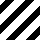
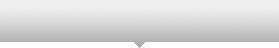
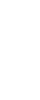
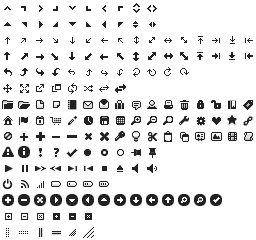
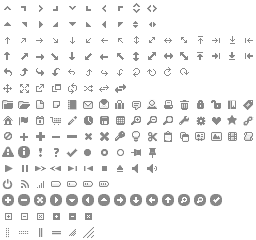
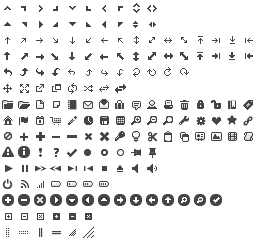
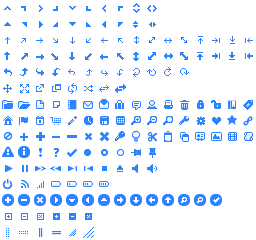
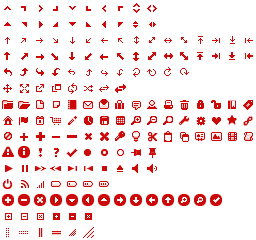
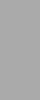
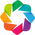
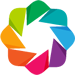
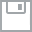
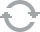
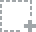
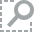
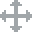
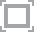
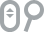

In [1]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn import metrics
from bokeh.plotting import figure, output_notebook, show, HBox, VBox, GridPlot, ColumnDataSource
from bokeh.charts import Donut
from bokeh.models import Range1d, HoverTool
import seaborn as sbn
import math
import matplotlib as mpl
from collections import OrderedDict

#Reduction dimensions
from sklearn.manifold import TSNE
from tsne import bh_sne
from sklearn.decomposition import PCA

#import from utils
import sys
sys.path.append('../')
from utils import *

output_notebook()

reg = pd.read_csv("../../../registers.csv", na_values=np.nan)
assig = pd.read_csv("../../../assigs.csv", na_values=np.nan)
conv = pd.read_csv("../../../conv.csv", na_values=np.nan)
qual = pd.read_csv("../../../qualifications.csv", na_values=np.nan)
qual_norm = pd.read_csv("../../../qualifications_normalized.csv", na_values=np.nan)

In [2]:
# Mostrem les columnes de cada taula, per tenir-la present
print reg.columns
print
print assig.columns
print
print qual.columns
print 
print conv.columns

Index([u'id_alumne', u'sexe', u'naixement', u'nacionalitat', u'simultaneitat', u'becat', u'priv_pub_cfgs', u'tipus_lloc_cfgs', u'lloc_cfgs', u'priv_pub_secundaria', u'tipus_lloc_secundaria', u'lloc_secundaria', u'desc_via_acces', u'id_via_acces', u'any_pau', u'universitat_procedencia', u'universitat_procedencia_desc', u'sistema_educatiu_estranger', u'pais_sistema_estranger', u'nota_acces', u'desc_enseny', u'id_enseny', u'any_primera_matricula'], dtype='object')

Index([u'id_assig', u'desc_assig', u'curs_assig', u'semestre_assig', u'id_enseny_assig', u'credits_assig'], dtype='object')

Index([u'any_matriculacio_assig', u'id_alumne', u'id_enseny', u'id_assig', u'tipus_apunt', u'nota_primera_conv', u'nota_segona_conv'], dtype='object')

Index([u'id_alumne', u'id_enseny', u'nota_mitja_grau', u'credits_superats', u'id_itinerari', u'itinerari_desc', u'dedicacio', u'num_assig_convalidades'], dtype='object')


In [3]:
reg_mates = reg[reg['id_enseny'] != 'G1077']
reg_info = reg[reg['id_enseny'] != 'G1042']

# Treiem les de info (G1077)
assig_mates = assig[assig['id_enseny_assig'] != 'G1077']

# Treiem les de mates (G1042)
assig_info = assig[assig['id_enseny_assig'] != 'G1042']

print "Tenim: "+str(len(reg))+" alumnes en total"
print str(len(reg_info))+" d'Enginyeria Informàtica + doble"
print str(len(reg_mates))+" de Matemàtiques + doble"
print
#Comprobem que els d'informàtica només tenen assignatures d'informàtica i
# que els de matemàtiques només tenen assignatures de matemàtiques.
print assig_info.id_enseny_assig.value_counts()
print
print assig_mates.groupby('id_enseny_assig').size()

Tenim: 966 alumnes en total
450 d'Enginyeria Informàtica + doble
516 de Matemàtiques + doble

G1077    48
dtype: int64

id_enseny_assig
G1042    46
dtype: int64


In [4]:
# En cada fila tenim la qualificació d'un alumne en una assignatura amb tota la informació
df_info = pd.merge(pd.merge(qual, assig_info), reg_info)
df_mates = pd.merge(pd.merge(qual, assig_mates), reg_mates)
display(df_info.ix[20])

any_matriculacio_assig                                                  2010
id_alumne                                                                  8
id_enseny                                                              G1077
id_assig                                                              364301
tipus_apunt                                                         Ordinari
nota_primera_conv                                                          0
nota_segona_conv                                                           0
desc_assig                                               Estructura de Dades
curs_assig                                                                 1
semestre_assig                                                             2
id_enseny_assig                                                        G1077
credits_assig                                                              6
sexe                                                                       H

In [5]:
# Primer del grau d'Enginyeria Informàtica
# * PROGRAMACIÓ I                -> 364288
# * DISSENY DIGITAL BÀSIC        -> 364289
# * INTRODUCCIÓ ALS ORDINADORS   -> 364290
# * ÀLGEBRA                      -> 364291
# * CÀLCUL                       -> 364292
# * MATEMÀTICA DISCRETA          -> 364293
# * FÍSICA                       -> 364294
# * ALGORÍSMICA                  -> 364298
# * PROGRAMACIÓ II               -> 364299
# * ESTRUCTURA DE DADES          -> 364301


s1_info = [364288, 364289, 364290, 364291, 364292, 364293, 364294, 364298, 364299, 364301]
s1_info_lbl = ['P1', 'DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'P2', 'ED']

# Segon del grau d'Enginyeria Informàtica
# * ELECTRÓNICA                              -> 364297
# * ALGORÍSMICA AVANÇADA                     -> 364300
# * DISSENY DE SOFTWARE                      -> 364303
# * ESTRUCTURA DE COMPUTADORS                -> 364305
# * INTRODUCCIÓ A LA COMPUTACIÓ CIENTÍFICA   -> 364302
# * EMPRESA                                  -> 364296
# * PROBABILITAT I ESTADÍSTICA               -> 364295
# * PROGRAMACIÓ D'ARQUITECTURES ENCASTADES   -> 364306
# * PROJECTE INTEGRAT DE SOFTWARE            -> 364304
# * SISTEMES OPERATIUS I                     -> 364307


s2_info = [364297, 364300, 364303, 364305, 364302, 364296, 364295, 364306, 364304, 364307]
s2_info_lbl = ['ELEC', 'AA', 'DS', 'EC', 'ICC', 'EMP', 'PIE', 'PAE', 'PIS', 'SO1']


# Tercer del grau d'Enginyeria Informàtica
# INTEL·LIGÈNCIA ARTIFICIAL              -> 364314
# SISTEMES OPERATIUS II                  -> 364308
# TALLER DE NOUS USOS DE LA INFORMÀTICA  -> 364322
# VISIÓ ARTIFICIAL                       -> 364315
# XARXES                                 -> 364309
# BASES DE DADES                         -> 364311
# FACTORS HUMANS I COMPUTACIÓ            -> 364323
# GRÀFICS I VISUALITZACIÓ DE DADES       -> 364328
# LÒGICA I LLENGUATGES                   -> 364310
# SOFTWARE DISTRIBUÏT                    -> 364312


s3_info = [364314, 364308, 364322, 364315, 364309, 364311, 364323, 364328, 364310, 364312]
s3_info_lbl = ['IA', 'SO2', 'TNUI', 'VA', 'XAR', 'BD', 'FHIC', 'GiVD', 'LIL', 'SWD']


# Primer del grau de Matemàtiques
# ANÀLISI DE DADES I INTRODUCCIÓ A LA PROBABILITAT    -> 360142
# ELEMENTS DE PROGRAMACIÓ                             -> 360140
# INTRODUCCIÓ AL CÀLCUL DIFERENCIAL                   -> 360136
# LLENGUATGE I RAONAMENT MATEMÀTIC                    -> 360138
# MATRIUS I VECTORS                                   -> 360134
# ÀLGEBRA LINEAL                                      -> 360135
# ARITMÈTICA                                          -> 360139
# FÍSICA                                              -> 360143
# INTRODUCCIÓ AL CÀLCUL INTEGRAL                      -> 360137
# PROGRAMACIÓ CIENTÍFICA                              -> 360141

s1_mates = [360142, 360140, 360136, 360138, 360134, 360135, 360139, 360143, 360137, 360141]
s1_mates_lbl = ['ADIP', 'ELPR', 'IACD', 'LIRM', 'MAVE', 'ALLI', 'ARIT', 'FISI', 'IACI', 'PRCI']

# Primer del grau de Matemàtiques
# CÀLCUL DIFERENCIAL EN DIVERSES VARIABLES    -> 360144
# ESTRUCTURES ALGEBRAIQUES                    -> 360148
# GEOMETRIA LINEAL                            -> 360151
# GRAFS                                       -> 360150
# MÈTODES NUMÈRICS I                          -> 360146
# CÀLCUL INTEGRAL EN DIVERSES VARIABLESS      -> 360145
# GEOMETRIA PROJECTIVA                        -> 360152
# HISTÒRIA DE LES MATEMÀTIQUES                -> 360161
# MODELS MATEMÀTICS I SISTEMES DINÀMICS       -> 360153
# TOPOLOGIA                                   -> 360155


s2_mates = [360144, 360148, 360151, 360150, 360146, 360145, 360152, 360161, 360153, 360155]
s2_mates_lbl = ['CDDV', 'ESAL', 'GELI', 'GRAF', 'MNU1', 'CIDV', 'GEPR', 'HIMA', 'MMSD', 'TOPO']

# Tercer del grau de Matemàtiques
# ANÀLISI MATEMÀTICA                              -> 360158
# EQUACIONS ALGEBRAIQUES                          -> 360149
# GEOMETRIA DIFERENCIAL DE CORBES I SUPERFÍCIES   -> 360156
# MÈTODES NUMÈRICS II                             -> 360147
# PROBABILITATS                                   -> 360162
# ANÀLISI COMPLEXA                                -> 360159
# EQUACIONS DIFERENCIALS                          -> 360154
# ESTADÍSTICA                                     -> 360163
# MODELITZACIÓ                                    -> 360160
# TOPOLOGIA I GEOMETRIA GLOBAL DE SUPERFÍCIES     -> 360157



s3_mates = [360158, 360149, 360156, 360147, 360162, 360159, 360154, 360163, 360160, 360157]
s3_mates_lbl = ['ANMA', 'EQAL', 'GDCS', 'MNU2', 'PROB', 'ANCO', 'EQDI', 'ESTA', 'MODE', 'TGGS']

    
primer_info_qual = table_students(df_info, s1_info)
display(primer_info_qual.head())

segon_info_qual = table_students(df_info, s2_info)
primer_info_qual.columns = s1_info_lbl
segon_info_qual.columns = s2_info_lbl

primer_mates_qual = table_students(df_mates, s1_mates)
segon_mates_qual = table_students(df_mates, s2_mates)
primer_mates_qual.columns = s1_mates_lbl
segon_mates_qual.columns = s2_mates_lbl

id_assig,364288,364289,364290,364291,364292,364293,364294,364298,364299,364301
id_alumne,,,,,,,,,,
8,8.2,0.8,0.0,0.0,0.0,0.0,0.0,2.4,0.0,0.0
9,7.0,10.0,5.7,7.0,8.8,7.3,6.2,8.0,8.6,7.1
11,5.6,8.0,6.0,6.0,6.0,6.2,6.0,6.6,6.7,5.1
15,5.0,10.0,8.4,8.4,8.6,8.1,5.2,6.7,7.5,6.0
18,6.1,0.0,0.0,6.0,6.0,0.0,0.0,2.2,0.0,0.0


In [6]:
df = select_rows_by_columns(df_info, primer_info_qual.index, 'id_alumne')
via_0 = df[df['id_via_acces'] ==  0].reset_index(drop=True) # Batxillerat/COU amb PAU
via_2 = df[df['id_via_acces'] ==  2].reset_index(drop=True) # Diplomat, Llicenciat
via_4 = df[df['id_via_acces'] ==  4].reset_index(drop=True) # FP2, CFGS
via_7 = df[df['id_via_acces'] ==  7].reset_index(drop=True) # Universitaris Batxillerat/COU amb PAU 
via_8 = df[df['id_via_acces'] ==  8].reset_index(drop=True)#  Universitaris FP2 / CFGS
via_78 = pd.concat([via_7, via_8]) # Universitaris
via_acces_info_desc = ['Batx', 'Dipl', 'CFGS', 'Uni']
via_acces_info = [via_0['id_alumne'], via_2['id_alumne'], via_4['id_alumne'], via_78['id_alumne']]

df = select_rows_by_columns(df_mates, primer_mates_qual.index, 'id_alumne')
via_0 = df[df['id_via_acces'] ==  0].reset_index(drop=True) # Batxillerat/COU amb PAU
via_2 = df[df['id_via_acces'] ==  2].reset_index(drop=True) # Diplomat, Llicenciat
via_4 = df[df['id_via_acces'] ==  4].reset_index(drop=True) # FP2, CFGS
via_7 = df[df['id_via_acces'] ==  7].reset_index(drop=True) # Universitaris Batxillerat/COU amb PAU 
via_8 = df[df['id_via_acces'] ==  8].reset_index(drop=True)#  Universitaris FP2 / CFGS
via_78 = pd.concat([via_7, via_8]) # Universitaris
via_acces_mates_desc = ['Batx', 'Dipl', 'CFGS', 'Uni']
via_acces_mates = [via_0['id_alumne'], via_2['id_alumne'], via_4['id_alumne'], via_78['id_alumne']]

## Obtenir una _k_ òptima

El nostre objectiu ara es clusteritzar els alumnes per les seves notes, però si utilitzem k-means, quina és _k_ òptima? Bé doncs, tot seguit expliquem les tècniques utilitzades. El que busquem són grups d'alumnes, aproximadament hauriem de sortir 3 o 4 (aprobats, bones notes, males notes i diferents perfils).

### Execució amb diferents ks

El primer que farem serà executar K-means amb diferents _k_. Per cada _k_ calculem el `silhouette_score` que ens diu quan de disgregat és el cluster. Com més alt el valor millor. Per visualitzar-ho, dibuixem una gràfica amb totes les _ks_ i el seu valor de _silhouette_.

In [7]:
def apply_multiple_kmeans(df, rang):
    data = df.values
    f = figure(x_range=rang, title="Silhouette score", plot_width=400, plot_height=400)
    sils = []
    ks = range(rang[0], rang[1])
    for k in ks:
        kmeans = KMeans(n_clusters=k, init='random', max_iter=200, n_init=10)
        kmeans.fit(data)
        sils.append(metrics.silhouette_score(data, kmeans.labels_,
                                          metric='euclidean',
                                          sample_size=300))
    f.line(x=ks, y=sils)
    show(f)

In [8]:
apply_multiple_kmeans(primer_info_qual, [2,16])

/home/zenbook/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [9]:
apply_multiple_kmeans(primer_mates_qual, [2,16])

Podem veure llavors que aquesta tècnica ens diu que la millor _k_ sempre és _k_=2, i conforme augmenta la _k_ el `silhouette_score` tendeix a disminuïr. No ens acaba de servir del tot això llavors, per això processem a utilitzar una altre tècnica.

### Reducció de dimensions amb PCA

Ara el que farem, serà reduïr les dimensions de les nostres dades. La dimensió que tenim és 10, doncs amb PCA (Principal Component Analysis) reduïrem les dimensions a 2, per a que poguin ser visualitzades.

Una vegada hem reduït les dimensions podem aplicar MeanShift i ens digui quan clusters trova, i si aquests són coherents i disgregats.

In [10]:
def reduction_clustering(df, title, func, estimator):
    tmp = df.copy()
    data = np.array(df.values)
    d = pd.DataFrame(func(data))
    estimator.fit(d.values)
    d['label'] = estimator.labels_
    k = len(set(estimator.labels_))
    print title,"-> Cluster trovats: ",k
    
    colors = seabornpalette_to_bokeh(sbn.hls_palette(k, l=0.4))

    f = figure(plot_width=450, plot_height=450, title=title)
    for i in range(k):
        data2D = d[d['label'] == i].values
        f.circle(data2D[:,0], data2D[:,1], color = colors[i], fill_alpha=0.6)
    return f
    

k=2
#estimator = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5)
estimator = MeanShift()
#estimator = DBSCAN()

model = PCA(n_components=2)
#model = TSNE(n_components=2, random_state=0)
#print model.noise_variance_
figures = []
figures.append(reduction_clustering(primer_info_qual, "Primer Informàtica", model.fit_transform, estimator))
figures.append(reduction_clustering(segon_info_qual, "Segon Informàtica", model.fit_transform, estimator))
figures.append(reduction_clustering(primer_mates_qual, "Primer Matemàtiques", model.fit_transform, estimator))
figures.append(reduction_clustering(segon_mates_qual, "Segon Matemàtiques", model.fit_transform, estimator))
show(get_gridplot(figures))
#reduction_clustering(primer_info_qual, bh_sne, estimator)


Primer Informàtica -> Cluster trovats:  6
Segon Informàtica -> Cluster trovats:  4
Primer Matemàtiques -> Cluster trovats:  3
Segon Matemàtiques -> Cluster trovats:  5


Amb aquesta tècnica ens dona un resultat més coherent amb el que hem supossat, entre 3 i 5 clusters, i a més es veuen força disgregats. 

## Representació de diferents clusters

Ara procedim a clusteritzar a partir de les _ks_ trobades anteriorment

In [11]:
# Curiós si clusteritzem amb 3 grups, trobem que un dels grups treu en general males notes, però en canvi a Càlcul i Matemàtiques discreta
# la nota es força alta en comparació. En resum, tenen més bones notes en assignatures de mates o hw, que en assignatures de software.
# Els altres dos clusters, tenim un que treu bones notes (mitja aprobada) i l'altre amb mitjes suspeses.
aprobat = [5 for i in range(10)]



def apply_clustering(df, estimator, lbl_clusters):
    tmp = df.copy()
    estimator.fit(tmp.values)
    if -1 in estimator.labels_:
        print "Not clustering"
        return None
    tmp['label'] = estimator.labels_
    k = len(set(estimator.labels_))

    data_qual = tmp.groupby('label').mean()
    describe_qual = tmp.groupby('label').describe()
    
    # deep, muted, pastel, bright, dark, and colorblind
    colors = seabornpalette_to_bokeh(sbn.color_palette("pastel", k))
        
    data = np.array(data_qual.values)
    figures = []
    counts = []
    i=0
    for d in data:
        counts.append(int(describe_qual.ix[i].ix['count'][0]))
        std = describe_qual.ix[i].ix['std']
        source_mark = ColumnDataSource(
            data=dict(
                mean=d,
                std=std
                )
            )
        
        f = figure(title=lbl_clusters[i],
                x_range=df.columns.tolist(), y_range=[0, 10], plot_width=425, plot_height=250,
                tools="pan,wheel_zoom,box_zoom,reset,hover"
        )
        f.xgrid.grid_line_color = None
        f.rect(x=df.columns, y=d/2, width=0.8, height=d, color=colors[i], alpha=0.8, source=source_mark) #colors[k]
        f.rect(x=df.columns, y=d, width=0.025, height=std*2, color='black', alpha=0.5)
        f.line(x=df.columns, y=aprobat, line_color='red')
        hover = f.select(dict(type=HoverTool))
        hover.tooltips = [
            ("mean", " @mean"),
            ("std", " @std")
        ]
        figures.append(f)
        i+=1
        #display(describe_qual.ix[i])
    gr = get_gridplot(figures)
    
    counts = [i/float(sum(counts)) for i in counts]
    percent = counts[:]
    for i in range(1,len(percent)):
        percent[i] += percent[i-1]
    percent.insert(0,0)
    starts = [p*2*math.pi for p in percent[:-1]]
    ends = [p*2*math.pi for p in percent[1:]]
    
    
    donut = figure(x_range=(-1.2,1.2), y_range=(-1.2,1.2), plot_width=450, plot_height=450, title="Distribució dels clusters")
    donut.xgrid.grid_line_color = None
    donut.ygrid.grid_line_color = None
    legend = []
    for i in counts:
        legend.append("%.2f%%" % (i*100))
    for i in range(len(starts)):
        donut.wedge(x=0, y=0, radius=1, start_angle=starts[i], end_angle=ends[i], color=colors[i], line_color = 'black', legend=legend[i])
    
    show(VBox(gr,HBox(donut)))
    
    return tmp, colors   

In [12]:
# Comprovem per cada grup quin és el percentatge d'alumnes per grup que no es matriculen als següents anys.
def renounce_chart(df, colors, register, subjects1, lbl):
    groups = []
    subjects1 = set(subjects1)
    for c in set(df['label']):
        d = df[df['label'] == c]
        count = 0.0
        for i in d.index:
            alumne = register[register['id_alumne'] == i]
            assig_alumne = set(alumne['id_assig'])
            #if
            if len(assig_alumne.intersection(subjects1)) == 0:
                count+=1
        groups.append((count/len(d.index))*100)
    groups = np.array(groups)
    
    source = ColumnDataSource(
        data=dict(
            percent=groups
            )
        )
    f = figure(title="Tassa d'abandonaments per cluster",
                x_range=lbl, y_range=[0,100], plot_width=900, plot_height=300,
                tools="pan,wheel_zoom,box_zoom,reset,hover")
    f.xgrid.grid_line_color = None
    f.rect(x=lbl, y=groups/2, width=0.3, height=groups, color=colors, alpha=0.8, source=source)
    hover = f.select(dict(type=HoverTool))
    hover.tooltips = [
        ("percert", " @percent")
    ]
    show(f)
        

In [13]:
def cross_cluster(src, src_lbl, dest, dest_lbl):
    out = {}
    for i in range(len(src)):
        out[src_lbl[i]] = {}
        for j in range(len(dest)):
            s = set(src[i])
            d = set(dest[j])
            if(len(s) == 0):
                ratio = np.nan
            else:
                ratio = len(s.intersection(d))
            if ratio == 0: # Posem els 0's a 1's, per a que el donut no sorti malament.
                ratio = 1
            out[src_lbl[i]][dest_lbl[j]] = ratio
    out = pd.DataFrame(out)
    #out2 = pd.DataFrame(out).transpose()
    # out1['sum'] = [np.sum(i) for i in out1.values]
    # out2['sum'] = [np.sum(i) for i in out2.values]
    #display(out)
    #display(out2)

    ordered = OrderedDict()
    for c in out.columns:
        ordered[c] = out[c].astype(float).values
    '''    
    ordered2 = OrderedDict()
    for c in out2.columns:
        ordered2[c] = out2[c].astype(float).values
    ''' 
    d = Donut(ordered, out.index.tolist())
    # d2 = Donut(ordered2, out2.index.tolist())
    # show(VBox(d,d2))
    show(d)

    


In [14]:
k=6
estimator = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5, random_state=42)
clusters_primer_info_lbl = ["BP1", # Bons en programació de primer
                            "BN1", # Bones notes de primer
                            "S1", # Suspesos de primer
                            "A1", # Aprovats de primer
                            "DP1", # Dolents en programció de primer
                            "BM1"] # "Bons" en matemàtiques de primer
tmp, colors = apply_clustering(primer_info_qual, estimator, clusters_primer_info_lbl)
renounce_chart(tmp, colors, df_info, s2_info, clusters_primer_info_lbl)
clusters_primer_info = [tmp[tmp['label'] == lbl].index for lbl in list(set(tmp['label']))]
cross_cluster(via_acces_info, via_acces_info_desc, clusters_primer_info, clusters_primer_info_lbl)

In [15]:
k=4
estimator = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5, random_state=42)
#estimator = MeanShift(bandwidth=10)
clusters_segon_info_lbl = ["BN2", # Bones notes de segon
                           "ISF1", #ICC i SO1 fluixes
                           "A2", # Aprovats de segon
                          "PPIE1"] #problemes amb pie
tmp, colors = apply_clustering(segon_info_qual, estimator, clusters_segon_info_lbl)
renounce_chart(tmp, colors, df_info, s3_info, clusters_segon_info_lbl)
clusters_segon_info = [tmp[tmp['label'] == lbl].index for lbl in list(set(tmp['label']))]
cross_cluster(clusters_primer_info, clusters_primer_info_lbl, clusters_segon_info, clusters_segon_info_lbl)

In [16]:
k=3
estimator = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5, random_state=42)
#estimator = MeanShift()
clusters_primer_mates_lbl = ["NE1", # No estables de primer
                             "A1", # Aprovats de primer
                             "S1"] # Suspesos de primer
tmp, colors = apply_clustering(primer_mates_qual, estimator, clusters_primer_mates_lbl)
renounce_chart(tmp, colors, df_mates, s2_mates, clusters_primer_mates_lbl)
clusters_primer_mates = [tmp[tmp['label'] == lbl].index for lbl in list(set(tmp['label']))]
cross_cluster(via_acces_mates, via_acces_mates_desc, clusters_primer_mates, clusters_primer_mates_lbl)

In [17]:
k=4
estimator = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5, random_state=42)
clusters_segon_mates_lbl = ["BN2", # Bones notes de segon
                             "AP2", # Apurats de segon
                             "NE2", # No estables de segon
                             "A2"] # Aprovats de segon
tmp, colors = apply_clustering(segon_mates_qual, estimator, clusters_segon_mates_lbl)
renounce_chart(tmp, colors, df_mates, s3_mates, clusters_segon_mates_lbl)
clusters_segon_mates = [tmp[tmp['label'] == lbl].index for lbl in list(set(tmp['label']))]
cross_cluster(clusters_primer_mates, clusters_primer_mates_lbl, clusters_segon_mates, clusters_segon_mates_lbl)